In [2]:
# from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
# from nilmtk.disaggregate import CO, FHMMExact, Hart85, Mean
# from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk_contrib.disaggregate import Seq2Seq, Seq2Point
# from nilmtk.utils import print_dict
from nilmtk.api import API
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.debugging.disable_traceback_filtering()
import pickle

In [23]:
experiment1 = {
    'power': {'mains': ['apparent','active'],'appliance': ['active']},
    'sample_rate': 30,
    'appliances': ['fridge', 'air conditioner', 'washing machine', 'tumble dryer', 'kettle', 'vacuum cleaner', 'electric water heating appliance', 'oven'],
    'methods': {"Seq2Seq":Seq2Seq({'sequence_length': 99}), "Seq2SPoint":Seq2Point({'sequence_length': 99})},
    'train': {
        'datasets': {
            'MIMOS': {
                'path': 'data/mimos_30_sec.h5',
                'buildings': {
                    1: {
                        'start_time': '2022-09-27',
                        'end_time': '2022-09-28'
                    },
                    2: {
                        'start_time': '2022-09-29',
                        'end_time': '2022-09-30'
                    },
                    3: {
                        'start_time': '2022-11-01',
                        'end_time': '2022-11-02'
                    },
                    4: {
                        'start_time': '2022-11-07',
                        'end_time': '2022-11-08'
                    },
                    6: {
                        'start_time': '2022-11-09',
                        'end_time': '2022-11-10'
                    },
                    7: {
                        'start_time': '2022-11-10',
                        'end_time': '2022-11-11'
                    }
                }
            }
        }
    },
    'test': {
        'datasets': {
            'MIMOS': {
                'path': 'data/mimos_30_sec.h5',
                'buildings': {
                    5: {
                        'start_time': '2022-11-08',
                        'end_time': '2022-11-09'
                    }
                }
            }
        },
        'metrics':['mae', 'rmse', 'f1score', 'nde']
    },
    'display_predictions': {
        True
    }
}

Joint Testing for all algorithms
Loading data for  MIMOS  dataset
Dropping missing values
Generating predictions for : Seq2Seq
9/9 [==============================] - 0s 31ms/step
Generating predictions for : Seq2Point
9/9 [==============================] - 1s 80ms/step
............  mae  ..............
                                     Seq2Seq  Seq2SPoint
fridge                            227.741486  194.254044
air conditioner                   278.516327  283.640137
washing machine                   209.455185  246.219971
tumble dryer                      119.947556  113.718262
kettle                            165.333084  106.825615
vacuum cleaner                     31.905003   33.200691
electric water heating appliance  170.705887  217.020538
oven                               19.659044   18.505117
............  rmse  ..............
                                     Seq2Seq  Seq2SPoint
fridge                            454.399226  538.687003
air conditioner                   

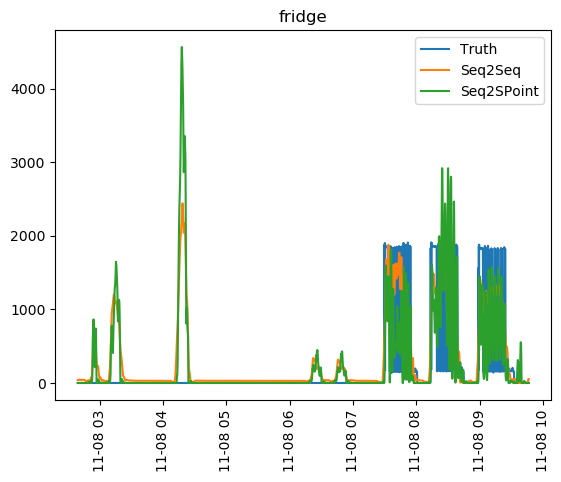

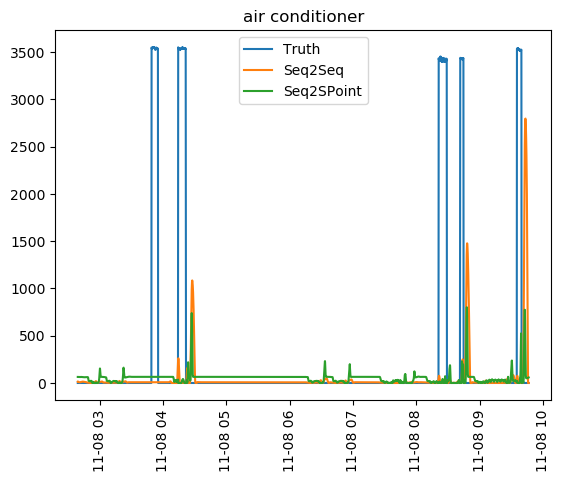

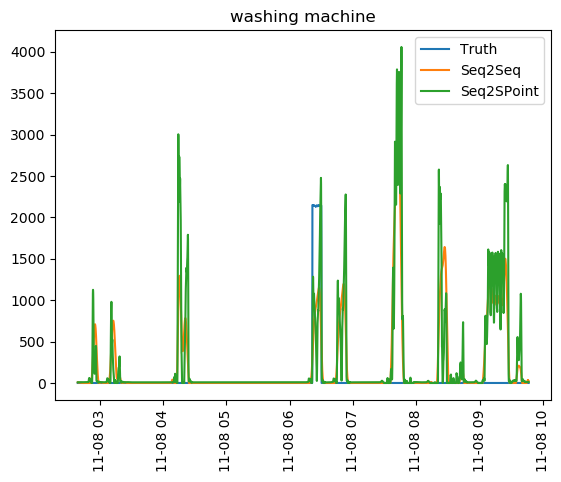

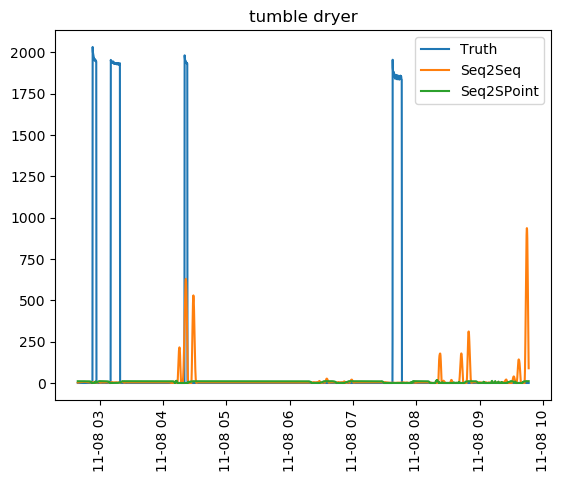

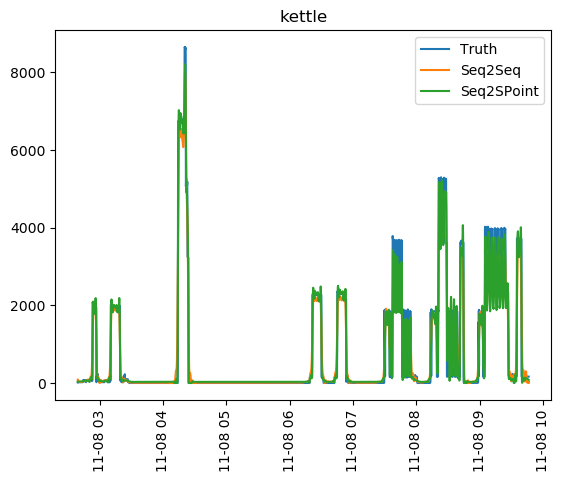

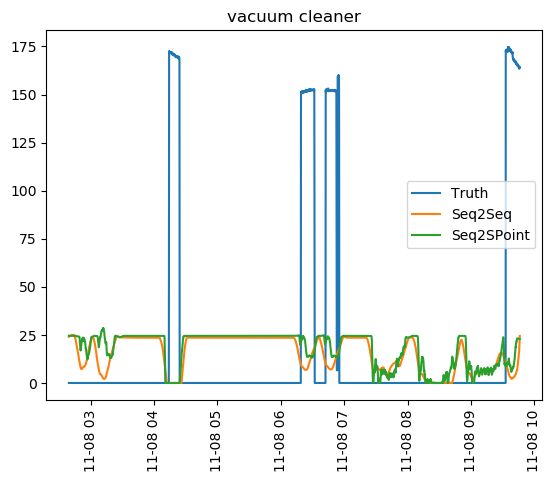

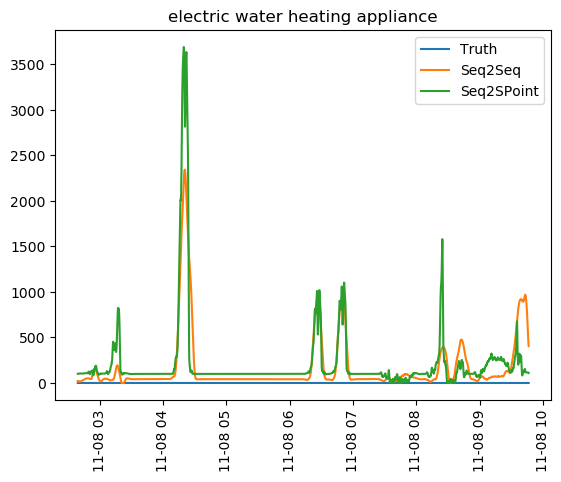

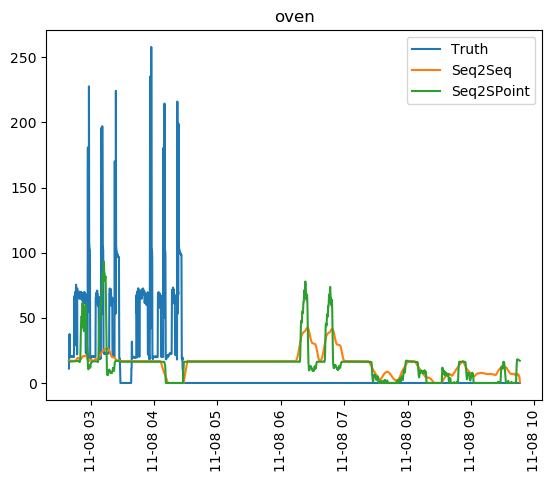

In [24]:
api_results_experiment_1 = API(experiment1)

In [13]:
def export_model(model,filename):
    example_dict = model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

In [25]:
export_model(api_results_experiment_1,'trained_models/6sec_99SL.pickle')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name

In [15]:
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [26]:
model = import_model('trained_models/6sec_99SL.pickle')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-04-21 18:29:00         4746
metadata.json                                  2024-04-21 18:29:00           64
variables.h5                                   2024-04-21 18:29:00      5409952
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
